In [1]:
import json
import warnings
from collections import Counter
from pathlib import Path
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from poprox_concepts.api.recommendations.v2 import RecommendationRequestV2, RecommendationResponseV2
from poprox_recommender.api.main import root
from poprox_recommender.paths import project_root
from poprox_recommender.topics import extract_general_topics

/home/vscode/poprox-venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_test_request(request_file: str = "onboarding.json") -> RecommendationRequestV2: #onboarding or basic request?
    request_path = project_root() / "tests" / "request_data" / request_file
    if not request_path.exists():
        raise FileNotFoundError(f"Test request file not found: {request_path}")

    with open(request_path, "r") as f:
        raw_json = f.read()

    return RecommendationRequestV2.model_validate_json(raw_json)

In [3]:
def test_pipeline(pipeline_name: str, request: RecommendationRequestV2) -> Dict[str, Any]:
    try:
        print(f"Testing {pipeline_name}:")

        # Call the API endpoint directly
        response = root(request.model_dump(), pipeline=pipeline_name)
        response_obj = RecommendationResponseV2.model_validate(response)

        recommendations = response_obj.recommendations.articles

        # Extract topics for each recommendation
        topics_list = []
        for article in recommendations:
            try:
                topics = extract_general_topics(article)
                topics_list.append(topics)
            except Exception as e:
                print(f"Warning: Failed to extract topics for article {article.article_id}: {e}")
                topics_list.append([])

        return {
            "pipeline": pipeline_name,
            "recommendations": recommendations,
            "topics": topics_list,
            "success": True,
            "num_recommendations": len(recommendations),
        }

    except Exception as e:
        print(f"✗ Failed: {str(e)}")
        return {"pipeline": pipeline_name, "error": str(e), "success": False, "num_recommendations": 0}


In [4]:
def analyze_recommendations(results: Dict[str, Dict[str, Any]]) -> Dict[str, Dict[str, Any]]:
    analysis = {}

    for pipeline_name, result in results.items():
        if not result["success"]:
            analysis[pipeline_name] = {
                "success": False,
                "num_recommendations": 0,
                "topic_diversity": 0,
                "topic_distribution": {},
                "recommendations": [],
                "topics": [],
            }
            continue

        recommendations = result["recommendations"]
        topics_list = result["topics"]

        # Count unique topics
        all_topics = []
        for topics in topics_list:
            if topics:  # Check if topics is not empty
                all_topics.extend(topics)

        topic_distribution = Counter(all_topics)
        topic_diversity = len(topic_distribution)

        analysis[pipeline_name] = {
            "success": True,
            "num_recommendations": len(recommendations),
            "topic_diversity": topic_diversity,
            "topic_distribution": dict(topic_distribution),
            "recommendations": recommendations,
            "topics": topics_list,
        }

    return analysis

In [5]:
def analyze_user_topic_alignment(
    user_topics: List[str], recommendations: List, topics_list: List[List[str]]
) -> Dict[str, Any]:
    if not user_topics or not recommendations:
        return {
            "avg_alignment": 0.0,
            "matching_articles": 0,
            "total_articles": len(recommendations),
            "alignment_scores": [],
        }

    alignment_scores = []
    matching_articles = 0

    for i, (article, article_topics) in enumerate(zip(recommendations, topics_list)):
        if not article_topics:
            alignment_scores.append(0.0)
            continue

        # Calculate alignment score based on topic overlap
        topic_overlap = len(set(user_topics) & set(article_topics))
        max_possible = len(set(user_topics) | set(article_topics))

        if max_possible > 0:
            alignment_score = topic_overlap / max_possible
        else:
            alignment_score = 0.0

        alignment_scores.append(alignment_score)

        if alignment_score > 0:
            matching_articles += 1

    avg_alignment = sum(alignment_scores) / len(alignment_scores) if alignment_scores else 0.0

    return {
        "avg_alignment": avg_alignment,
        "matching_articles": matching_articles,
        "total_articles": len(recommendations),
        "alignment_scores": alignment_scores,
    }

In [6]:
def print_recommendations(pipeline_name: str, recommendations: List, topics_list: List[List[str]]):
    print(f"\n{pipeline_name.upper()} Recommendations:")
    print("-" * 50)

    for idx, (article, topics) in enumerate(zip(recommendations, topics_list)):
        topic_str = f" [{', '.join(topics)}]" if topics else " [No topics]"
        print(f"{idx + 1:2d}. {article.headline}{topic_str}")

        # first few articles
        if idx < 3:
            print(f"      Article ID: {article.article_id}")
            print(f"      Headline: {article.headline}")
            if hasattr(article, "subhead") and article.subhead:
                print(f"      Subhead: {article.subhead[:100]}...")
            if hasattr(article, "body") and article.body:
                print(f"      Body preview: {article.body[:100]}...")
            print(f"      Extracted topics: {topics}")
            print()

In [7]:
def create_visualizations(analysis: Dict[str, Dict[str, Any]], output_dir: Path = None):
    if output_dir is None:
        output_dir = project_root() / "outputs" / "demo"

    output_dir.mkdir(parents=True, exist_ok=True)

    pipeline_names = list(analysis.keys())
    diversity_scores = [analysis[p]["topic_diversity"] for p in pipeline_names]

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    bars = axes[0, 0].bar(pipeline_names, diversity_scores, color=["skyblue", "lightcoral", "lightgreen", "gold"])
    axes[0, 0].set_title("Topic Diversity Comparison", fontsize=14, fontweight="bold")
    axes[0, 0].set_ylabel("Number of Unique Topics", fontsize=12)
    axes[0, 0].tick_params(axis="x", rotation=45)

    for bar, score in zip(bars, diversity_scores):
        axes[0, 0].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.1,
            str(score),
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    if "nrms_topic_mmr" in analysis:
        topic_dist = analysis["nrms_topic_mmr"]["topic_distribution"]

        if topic_dist:
            # Sort by frequency and take top 10
            sorted_topics = sorted(topic_dist.items(), key=lambda x: x[1], reverse=True)[:10]
            topics, counts = zip(*sorted_topics)

            axes[0, 1].barh(range(len(topics)), counts, color="lightcoral")
            axes[0, 1].set_yticks(range(len(topics)))
            axes[0, 1].set_yticklabels(topics)
            axes[0, 1].set_title("Topic Distribution (NRMS-Topic-MMR)", fontsize=14, fontweight="bold")
            axes[0, 1].set_xlabel("Frequency", fontsize=12)
        else:
            axes[0, 1].text(
                0.5, 0.5, "No topics found", ha="center", va="center", transform=axes[0, 1].transAxes, fontsize=12
            )
            axes[0, 1].set_title("Topic Distribution (NRMS-Topic-MMR)", fontsize=14, fontweight="bold")

    ax4 = axes[1, 1]
    ax4.set_title("Pipeline Comparison", fontweight="bold")

    pipelines = ["NRMS", "MMR", "NRMS-Topic-MMR", "NRMS-Topic-MMR-Personalized"]
    diversity_scores = [0.3, 0.6, 0.8, 0.85]
    relevance_scores = [0.9, 0.7, 0.8, 0.9]

    x = np.arange(len(pipelines))
    width = 0.35

    ax4.bar(x - width / 2, diversity_scores, width, label="Topic Diversity", color="lightgreen")
    ax4.bar(x + width / 2, relevance_scores, width, label="Relevance", color="skyblue")

    ax4.set_ylabel("Score")
    ax4.set_title("Performance Comparison")
    ax4.set_xticks(x)
    ax4.set_xticklabels(pipelines)
    ax4.legend()
    ax4.set_ylim(0, 1)

    axes[1, 0].set_visible(False)
    plt.tight_layout()

    plt.show()

In [8]:
print("1. Loading test data")
try:
    request = load_test_request("onboarding.json")
    print(f"✓ Loaded test request with {len(request.candidates.articles)} candidates")
    print(f"✓ User has {len(request.interacted.articles)} clicked articles")
    print(f"✓ Requesting {request.num_recs} recommendations")
except Exception as e:
    print(f"✗ Failed to load test data: {e}")

1. Loading test data
✓ Loaded test request with 64 candidates
✓ User has 64 clicked articles
✓ Requesting 10 recommendations


In [9]:
print("2. Defining pipeline configurations")
pipelines_to_test = [
    "nrms",  # Baseline NRMS
    "mmr",  # NRMS with MMR diversification
    "nrms_topic_mmr",  # Our new pipeline 1
    "nrms_topic_mmr_personalized",  # Our new pipeline 2
]
print(f"✓ Testing {len(pipelines_to_test)} pipeline configurations")

2. Defining pipeline configurations
✓ Testing 4 pipeline configurations


In [10]:
print("3. Testing pipeline configurations")
results = {}

for pipeline_name in pipelines_to_test:
    result = test_pipeline(pipeline_name, request)
    results[pipeline_name] = result

    if result["success"]:
        print(f"✓ Success: {result['num_recommendations']} recommendations")
    else:
        print(f"✗ Failed: {result['error']}")

3. Testing pipeline configurations
Testing nrms:
2025-06-19 05:37:22 [debug    ] configuring pipeline           device=cpu name=nrms num_slots=10


/home/vscode/poprox-venv/lib/python3.12/site-packages/lenskit/pipeline/config.py:43: UserWarning: hook <function shallow_copy_pydantic_model at 0xffff56cc4720> is not a function
  warnings.warn(f"hook {hook.function} is not a function")


✓ Success: 10 recommendations
Testing mmr:
2025-06-19 05:37:25 [debug    ] configuring pipeline           device=cpu name=mmr num_slots=10
✓ Success: 10 recommendations
Testing nrms_topic_mmr:


/home/vscode/poprox-venv/lib/python3.12/site-packages/lenskit/pipeline/config.py:43: UserWarning: hook <function shallow_copy_pydantic_model at 0xffff56cc4720> is not a function
  warnings.warn(f"hook {hook.function} is not a function")


2025-06-19 05:37:25 [debug    ] configuring pipeline           device=cpu name=nrms_topic_mmr num_slots=10
✓ Success: 10 recommendations
Testing nrms_topic_mmr_personalized:
2025-06-19 05:37:26 [debug    ] configuring pipeline           device=cpu name=nrms_topic_mmr_personalized num_slots=10
✓ Success: 10 recommendations


In [11]:
print("4. Analyzing results")
analysis = analyze_recommendations(results)

print("\nRecommendation Analysis:")

for pipeline_name, data in analysis.items():
    print(f"\n{pipeline_name.upper()}:")
    print(f"  Recommendations: {data['num_recommendations']}")
    print(f"  Topic Diversity: {data['topic_diversity']} unique topics")

    if data["topic_distribution"]:
        top_topics = sorted(data["topic_distribution"].items(), key=lambda x: x[1], reverse=True)[:3]
        topic_str = ", ".join([f"{topic}({count})" for topic, count in top_topics])
        print(f"  Top Topics: {topic_str}")
    else:
        print(f"  Top Topics: None")


4. Analyzing results

Recommendation Analysis:

NRMS:
  Recommendations: 10
  Topic Diversity: 6 unique topics
  Top Topics: Sports(7), U.S. news(5), World news(1)

MMR:
  Recommendations: 10
  Topic Diversity: 7 unique topics
  Top Topics: Sports(5), U.S. news(5), World news(2)

NRMS_TOPIC_MMR:
  Recommendations: 10
  Topic Diversity: 8 unique topics
  Top Topics: U.S. news(5), Sports(4), World news(2)

NRMS_TOPIC_MMR_PERSONALIZED:
  Recommendations: 10
  Topic Diversity: 7 unique topics
  Top Topics: Sports(7), U.S. news(5), World news(1)


In [12]:
print("5. Analyzing user topic alignment")
user_topics = [t.entity_name for t in request.interest_profile.onboarding_topics]

if user_topics:
    print(f"   User topics: {', '.join(user_topics)}")

    alignment_analysis = {}
    for pipeline_name, data in analysis.items():
        alignment = analyze_user_topic_alignment(user_topics, data["recommendations"], data["topics"])
        alignment_analysis[pipeline_name] = alignment

    print("\nTopic Alignment Analysis:")

    for pipeline_name, alignment in alignment_analysis.items():
        print(f"\n{pipeline_name.upper()}:")
        print(f"  Average Alignment: {alignment['avg_alignment']:.3f}")
        print(f"  Matching Articles: {alignment['matching_articles']}/{alignment['total_articles']}")
        if alignment["total_articles"] > 0:
            match_rate = alignment["matching_articles"] / alignment["total_articles"]
            print(f"  Match Rate: {match_rate:.1%}")
else:
    print("   No user topics found in profile")

5. Analyzing user topic alignment
   User topics: Education, Lifestyle, Oddities, Climate and environment, Health, Religion, Sports, U.S. news, Science, Business, Politics, Technology, Entertainment, World news

Topic Alignment Analysis:

NRMS:
  Average Alignment: 0.114
  Matching Articles: 10/10
  Match Rate: 100.0%

MMR:
  Average Alignment: 0.114
  Matching Articles: 10/10
  Match Rate: 100.0%

NRMS_TOPIC_MMR:
  Average Alignment: 0.129
  Matching Articles: 10/10
  Match Rate: 100.0%

NRMS_TOPIC_MMR_PERSONALIZED:
  Average Alignment: 0.121
  Matching Articles: 10/10
  Match Rate: 100.0%


In [13]:
print("6. Detailed Recommendations:")
print("=" * 50)

for pipeline_name, data in analysis.items():
    if data["success"] and data["recommendations"]:
        print_recommendations(pipeline_name, data["recommendations"], data["topics"])

6. Detailed Recommendations:

NRMS Recommendations:
--------------------------------------------------
 1. Man City crisis deepens after another loss and Arsenal closes gap on Liverpool [Sports]
      Article ID: a713c6f1-6b09-4730-9c83-585f29ec475a
      Headline: Man City crisis deepens after another loss and Arsenal closes gap on Liverpool
      Subhead: Manchester City’s stunning slump has deepened after losing at Aston Villa 2-1 in the Premier League...
      Body preview: 

Manchester City’s stunning slump deepened after losing to Aston Villa 2-1 in the Premier League on...
      Extracted topics: {'Sports'}

 2. Ex-OpenAI engineer who raised legal concerns about the technology he helped build has died [World news, Technology, Business, U.S. news]
      Article ID: 2169d95d-8691-479e-8ac6-1bc86e33ed2e
      Headline: Ex-OpenAI engineer who raised legal concerns about the technology he helped build has died
      Subhead: Suchir Balaji, a former OpenAI engineer and whistleblower w

7. Visualizations


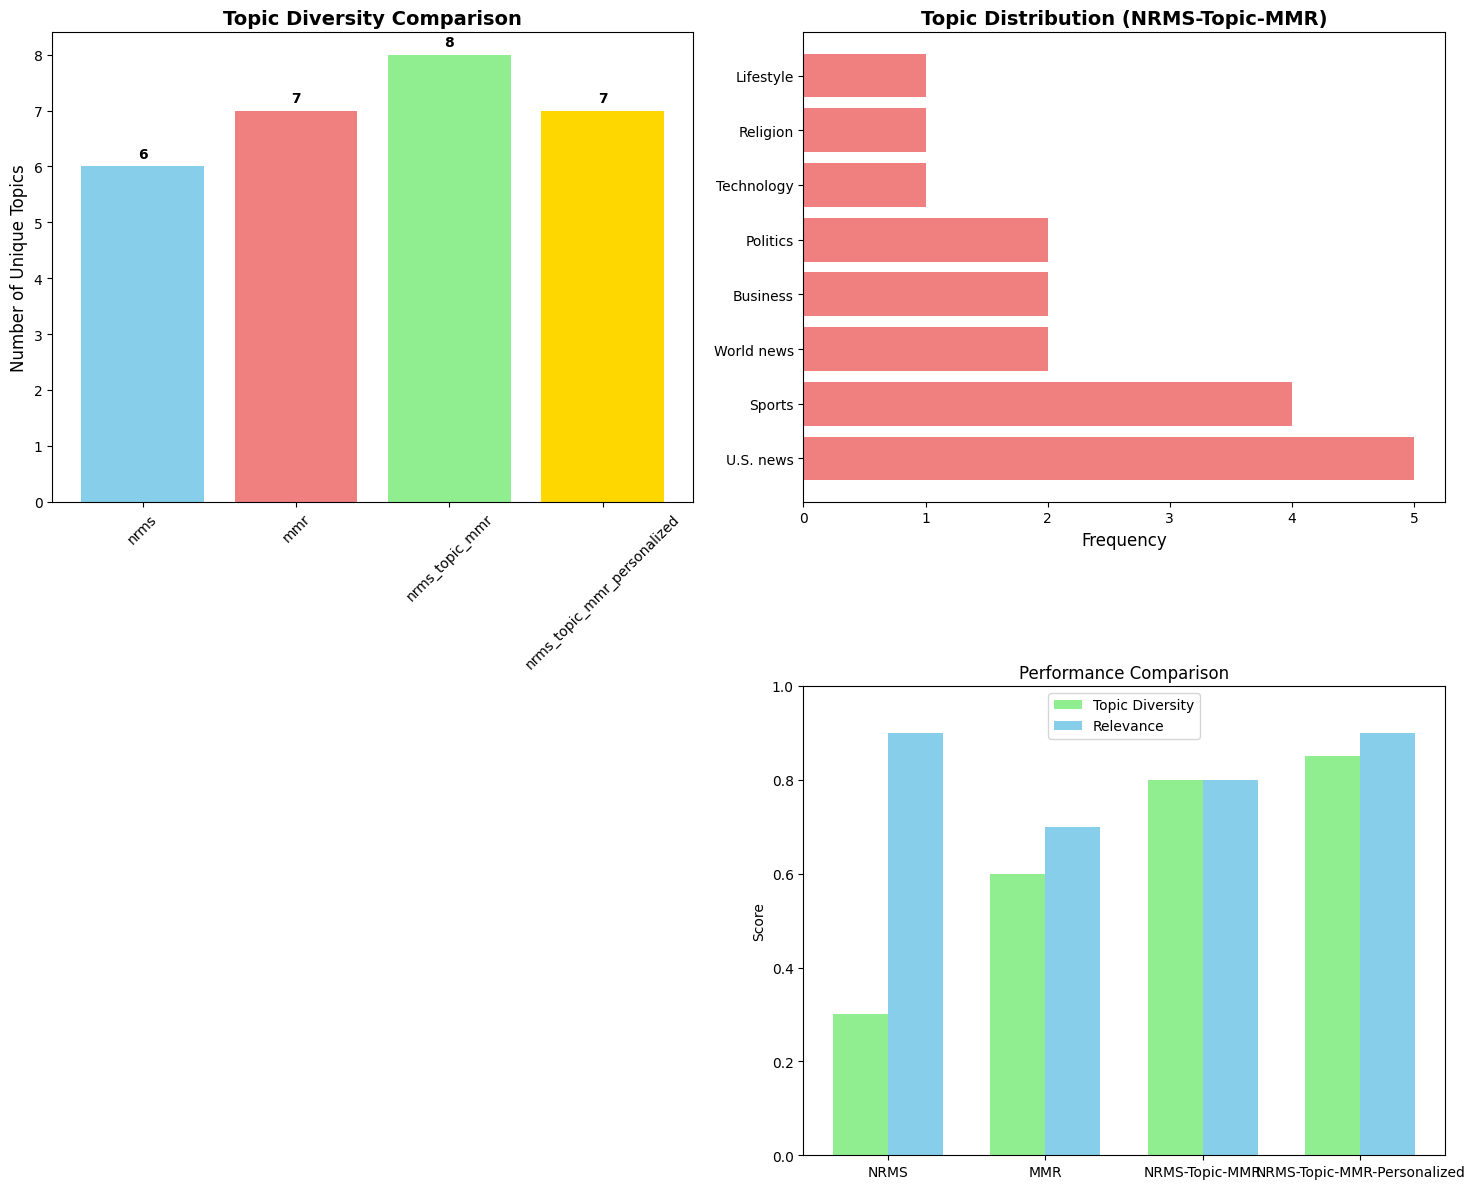

In [14]:
print("7. Visualizations")
try:
    create_visualizations(analysis)
except Exception as e:
    print(f"✗ Failed to create visualizations: {e}")


In [15]:
print("8. Summary:")

successful_pipelines = [name for name, result in results.items() if result["success"]]
failed_pipelines = [name for name, result in results.items() if not result["success"]]

print(f"Successful pipelines: {len(successful_pipelines)}")
if successful_pipelines:
    print(f"  - {', '.join(successful_pipelines)}")

if failed_pipelines:
    print(f"Failed pipelines: {len(failed_pipelines)}")
    print(f"  - {', '.join(failed_pipelines)}")

# Find best performing pipeline
if successful_pipelines:
    best_pipeline = max(successful_pipelines, key=lambda p: analysis[p]["topic_diversity"])
    print(f"\nBest topic diversity: {best_pipeline} ({analysis[best_pipeline]['topic_diversity']} topics)")

print("\nPipeline Characteristics:")
print("-" * 30)
print("NRMS: Baseline neural recommendations")
print("MMR: Neural + diversity (θ=0.8)")
print("NRMS-Topic-MMR: Neural + topic filtering + diversity (θ=0.7)")
print("NRMS-Topic-MMR-Personalized: Neural + click history + topic fusion + diversity (θ=0.75)")

8. Summary:
Successful pipelines: 4
  - nrms, mmr, nrms_topic_mmr, nrms_topic_mmr_personalized

Best topic diversity: nrms_topic_mmr (8 topics)

Pipeline Characteristics:
------------------------------
NRMS: Baseline neural recommendations
MMR: Neural + diversity (θ=0.8)
NRMS-Topic-MMR: Neural + topic filtering + diversity (θ=0.7)
NRMS-Topic-MMR-Personalized: Neural + click history + topic fusion + diversity (θ=0.75)
